<a href="https://colab.research.google.com/github/HeTalksInMaths/DeepMLProj-OEIS/blob/main/Deep_Learning_Project_OEIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fixed Time-Step Numerical Sequence Learning

# Project Overiew


While recurrent neural networks h

Two approaches

Tax planning Dec 31 market prices, final room occupancy nights etc. Stocks may not necessarily be considered as samples drawn from the same distribution especially if the sample set is not particularly large.

Is information specific to the time-step more important in model fitting or is information from all sequences (especially if they are not drawn from the same distribution)
.

Experimental proceducure for time-series requires generallyr requires additional care to avoid data leakage in comparison to standard supervised learning. Two approaches will be considered here with the aim of learning the 10th sequence value in OEIS sequences. Validation sets are constructed for hyperparameter tuning and avoid model overfitting to ensure generalizability.


Aim to help further understanding of how strongly subsets of sequences within OEIS are related to one another and if there is inherent structure across them.


The github repository link is located here: https://github.com/HeTalksInMaths/DeepMLProj-OEIS

# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns

# Loading Data

In [2]:
fileid='1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip'
filename='oeis.csv'

!wget -O $filename 'https://docs.google.com/uc?export=download&id='$fileid

--2022-12-06 23:00:52--  https://docs.google.com/uc?export=download&id=1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip
Resolving docs.google.com (docs.google.com)... 142.251.16.100, 142.251.16.101, 142.251.16.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hqll1i7b4n6th5k2fad2djcbu9o6du6j/1670367600000/02208792382482262317/*/1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip?e=download&uuid=85aa7878-f968-455e-8efe-d1303bf41661 [following]
--2022-12-06 23:00:57--  https://doc-0o-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hqll1i7b4n6th5k2fad2djcbu9o6du6j/1670367600000/02208792382482262317/*/1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip?e=download&uuid=85aa7878-f968-455e-8efe-d1303bf41661
Resolving doc-0o-4k-docs.googleusercontent.com (doc-0o-4k-docs.googleusercontent.com)... 172.217.1.193, 2607:f8b0:4

In [3]:
dfseq = pd.read_csv('/content/oeis.csv', header=None, skiprows=4, usecols=range(11), names=["Sequence", 
                                                                                                        '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

for c in dfseq.columns[1:]:
  dfseq[c] = pd.to_numeric(dfseq[c], errors='coerce', downcast="integer")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploratory Data Analysis (EDA)

In [4]:
dfseq.head()

,Sequence,1,2,3,4,5,6,7,8,9,10
0,A000001,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,5.0,2.0
1,A000002,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0
2,A000003,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0
3,A000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A000005,1.0,2.0,2.0,3.0,2.0,4.0,2.0,4.0,3.0,4.0


In [5]:
dfseq.shape

(351519, 11)

In [6]:
dfseq.dropna(axis=0, inplace = True)
dfseq.shape

(330583, 11)

In [7]:
np.max(dfseq.select_dtypes(include=np.number), axis = 0)

1     1.111111e+127
2      3.402824e+38
3      1.000000e+63
4      2.975857e+79
5     9.046413e+110
6      5.555556e+70
7     2.222222e+205
8     1.307539e+167
9      3.187368e+96
10    8.855667e+163
dtype: float64

In [8]:
np.mean(dfseq.select_dtypes(include=np.number), axis = 0)

1     3.734517e+121
2      1.029400e+33
3      6.049918e+57
4      9.002553e+73
5     2.736503e+105
6      1.680533e+65
7     6.722131e+199
8     3.955251e+161
9      9.641659e+90
10    2.678803e+158
dtype: float64

In [9]:
np.median(dfseq.select_dtypes(include=np.number), axis = 0)

array([  1.,   3.,   6.,  12.,  21.,  33.,  55.,  83., 119., 152.])

In [10]:
dfseq_red = dfseq[(dfseq[dfseq.columns[1:11]] <= 100).sum(1) > 9]
dfseq_red = dfseq_red[(dfseq_red[dfseq_red.columns[1:11]] >= 0).sum(1) > 9]

In [11]:
dfseq_red.shape

(137892, 11)

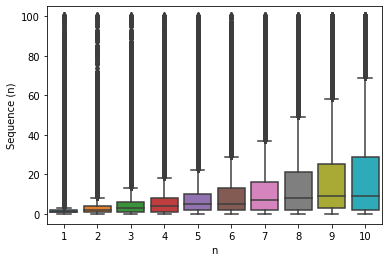

In [12]:
dfseq_red_long = dfseq_red.melt(id_vars = ['Sequence'], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot( x=dfseq_red_long["n"], y=dfseq_red_long["Sequence (n)"] );
plt.show()

In [13]:
dfseq_1000 = dfseq_red.sample(1000, random_state=0)

In [14]:
dfseq_1000.shape

(1000, 11)

In [15]:
dfseq_1000.head()

,Sequence,1,2,3,4,5,6,7,8,9,10
206739,A206740,1.0,1.0,1.0,1.0,2.0,3.0,4.0,6.0,9.0,13.0
253080,A253081,1.0,3.0,5.0,8.0,10.0,14.0,17.0,22.0,24.0,28.0
76987,A076988,2.0,3.0,13.0,5.0,21.0,13.0,8.0,89.0,55.0,21.0
65433,A065434,2.0,1.0,0.0,2.0,2.0,0.0,3.0,9.0,6.0,3.0
26475,A026476,1.0,3.0,4.0,9.0,12.0,23.0,26.0,37.0,40.0,51.0


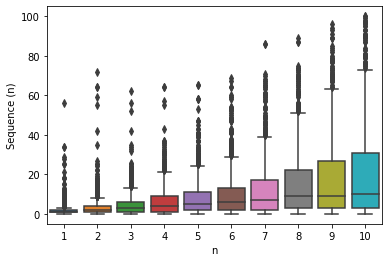

In [16]:
dfseq_1000_long = dfseq_1000.melt(id_vars = ['Sequence'], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot( x=dfseq_1000_long["n"], y=dfseq_1000_long["Sequence (n)"] );
plt.show()

In [17]:
np.mean(dfseq_red.select_dtypes(include=np.number))

1      2.044390
2      3.241943
3      4.664962
4      6.194616
5      7.935711
6      9.499384
7     11.746947
8     14.303187
9     16.718787
10    19.064971
dtype: float64

In [18]:
np.median(np.array(dfseq_red.select_dtypes(include=np.number)), axis = 0)

array([1., 2., 3., 4., 5., 5., 7., 8., 9., 9.])

In [19]:
np.mean(dfseq_1000.select_dtypes(include=np.number))

1      1.856
2      3.426
3      4.708
4      6.359
5      8.190
6     10.004
7     12.256
8     15.241
9     17.607
10    20.174
dtype: float64

In [20]:
np.median(np.array(dfseq_1000.select_dtypes(include=np.number)), axis = 0)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  9.,  9., 10.])

In [21]:
X = np.array(dfseq_1000.drop(columns = ['Sequence', '10']))
y = np.array(dfseq_1000['10'])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/9, random_state=0) # 2/9 x 0.9 = 0.2

In [23]:
X_train.shape

(700, 9)

In [24]:
np.mean(X_train, axis = 0)

array([ 1.94      ,  3.47857143,  4.98      ,  6.5       ,  8.46857143,
       10.24857143, 12.45428571, 15.32428571, 17.70142857])

In [25]:
np.mean(y_train)

20.338571428571427

# Experimental Setup

1) Train / Val / Test split where sequences are samples.

2) See how growth informs. First 7 to 8 in train, First 8 to 9 in val, first 9 to 10 in test but restricted to test 100 in the prior experimental setup.

Use Simple RNN which implementation in Keras has fully connected between RNNs as sequences are short and shouldn't have to worry about vanishing or exploding gradients in long sequences.

In [26]:
y_pred = X_val[:, -1]
np.mean(keras.losses.mean_absolute_error(y_val, y_pred))

6.34

#Method 1 Hyperparameter Tuning


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model1.compile(loss="mae", optimizer="adam")
history1 = model1.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

Epoch 1/500


In [ ]:
model1.summary()

In [ ]:
plt.plot(range(1,len(history1.history['loss']) + 1), history1.history['loss'])
plt.plot(range(1, len(history1.history['loss']) + 1) , history1.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model2.compile(loss="mae", optimizer="adam")
history2 = model2.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

In [ ]:
plt.plot(range(1,len(history2.history['loss']) + 1), history2.history['loss'])
plt.plot(range(1, len(history2.history['loss']) + 1) , history2.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model3 = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model3.compile(loss="mae", optimizer="adam")
history3 = model3.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

In [ ]:
plt.plot(range(1,len(history3.history['loss']) + 1), history3.history['loss'])
plt.plot(range(1, len(history3.history['loss']) + 1) , history3.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model4 = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model4.compile(loss="mae", optimizer="adam")
history4 = model4.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

In [ ]:
plt.plot(range(1,len(history4.history['loss']) + 1), history4.history['loss'])
plt.plot(range(1, len(history4.history['loss']) + 1) , history4.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model5 = keras.models.Sequential([
    keras.layers.SimpleRNN(200, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model5.compile(loss="mae", optimizer="adam")
history5 = model5.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

In [ ]:
plt.plot(range(1,len(history5.history['loss']) + 1), history5.history['loss'])
plt.plot(range(1, len(history5.history['loss']) + 1) , history5.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(500, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model6.compile(loss="mae", optimizer="adam")
history6 = model6.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

In [ ]:
plt.plot(range(1,len(history6.history['loss']) + 1), history6.history['loss'])
plt.plot(range(1, len(history6.history['loss']) + 1) , history6.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
models = [model1, model2, model3, model4, model5, model6]
maes_train = []
maes_val = []

for model in models:
  preds_train = model.predict(X_train)
  preds_val = model.predict(X_val)
  maes_train.append(np.mean(abs(preds_train[:,0] - y_train)))
  maes_val.append(np.mean(abs(preds_val[:,0] - y_val)))

In [ ]:
units = [10,20,50,100,200,500]

plt.plot(units, maes_train)
plt.plot(units , maes_val)
plt.title('Mean Absolute Error vs RNN Units')
plt.ylabel('Mean Absolute Error')
plt.xlabel('RNN Units')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
maes_val

In [ ]:
model6.summary()

|Units|Mean Absolute Error (Validation)|
|:----|:--------:|
|10|6.161|
|20|5.119|
|50|5.332|
|100|4.635|
|200|4.706|
|500|4.531|

Debatle how many units to use as not much variation in validation error between 100, 200 and 500 RNN units (largest three models). Could use 100 but will use 500.

In [ ]:
preds = model6.predict(X_test)
np.mean(abs(preds[:,0] - y_test))

In [ ]:
np.mean(preds[:,0] - y_test)

# Method 2 Hyperparameter Tuning

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model7 = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model7.compile(loss="mae", optimizer="adam")
history7 = model7.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

In [ ]:
plt.plot(range(1,len(history7.history['loss']) + 1), history7.history['loss'])
plt.plot(range(1, len(history7.history['loss']) + 1) , history7.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model8 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model8.compile(loss="mae", optimizer="adam")
history8 = model8.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

In [ ]:
plt.plot(range(1,len(history8.history['loss']) + 1), history8.history['loss'])
plt.plot(range(1, len(history8.history['loss']) + 1) , history8.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model9 = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model9.compile(loss="mae", optimizer="adam")
history9 = model9.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

In [ ]:
plt.plot(range(1,len(history9.history['loss']) + 1), history9.history['loss'])
plt.plot(range(1, len(history9.history['loss']) + 1) , history9.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model10 = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model10.compile(loss="mae", optimizer="adam")
history10 = model10.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

In [ ]:
plt.plot(range(1,len(history10.history['loss']) + 1), history10.history['loss'])
plt.plot(range(1, len(history10.history['loss']) + 1) , history10.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model11 = keras.models.Sequential([
    keras.layers.SimpleRNN(200, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model11.compile(loss="mae", optimizer="adam")
history11 = model11.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

In [ ]:
plt.plot(range(1,len(history11.history['loss']) + 1), history11.history['loss'])
plt.plot(range(1, len(history11.history['loss']) + 1) , history11.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model12 = keras.models.Sequential([
    keras.layers.SimpleRNN(500, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model12.compile(loss="mae", optimizer="adam")
history12 = model12.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

In [ ]:
plt.plot(range(1,len(history12.history['loss']) + 1), history12.history['loss'])
plt.plot(range(1, len(history12.history['loss']) + 1) , history12.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
models = [model7, model8, model9, model10, model11, model12]
maes_train = []
maes_val = []

for model in models:
  preds_train = model.predict(X[:,:7])
  preds_val = model.predict(X[:,:8])
  maes_train.append(np.mean(abs(preds_train[:,0] - X[:,7])))
  maes_val.append(np.mean(abs(preds_val[:,0] - X[:,8])))

In [ ]:
X[:,7].shape




Now try from 1000 to 10000 to 100000 and see if anything changes between methods.

In [ ]:
units = [10,20,50,100,200,500]

plt.plot(units, maes_train)
plt.plot(units , maes_val)
plt.title('Mean Absolute Error vs RNN Units')
plt.ylabel('Mean Absolute Error')
plt.xlabel('RNN Units')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
maes_val

|Units|Mean Absolute Error (Validation)|
|:----|:--------:|
|10|5.396|
|20|5.199|
|50|4.901|
|100|4.661|
|200|4.921|
|500|4.556|

In [ ]:
preds = model12.predict(X_test)
np.mean(abs(preds[:,0] - y_test))

In [ ]:
np.mean(preds[:,0] - y_test)

In [ ]:
np.mean(abs(X_test[:,-1] - y_test))

In [ ]:
np.mean(X_test[:,-1] - y_test)

# Results Summary

|Method|Mean Absolute Error (Test)|
|:----|:--------:|
|Benchmark|5.270|
|1|3.440|
|2|5.444|

The above table is 

# Conclusion

Two competing experimental design approaches are considered in determining how to best utilize recurrent neural networks (RNNs) in integer sequence learning using sequences from the Online Encyclopedia of Integer Sequence (OEIS). In particular, predicting specifically the tenth sequence value from the first nine can be achieved by fitting a model on different sequences at the corresponding sequence values or on the same sequences at earlier sequence values. Generalizability is better achieved using the former of these, meaning in this instance the fixed time-step under consideration potentially encodes usable information.

Fitting to 10th sequence value leads to better generalizability across sequences. Even with only 1000 sampled sequences.

Next step -consider other / larger samples of sequences or  different time-steps. Expand to different data sets.
